In [1]:
# make sure jupyter path is correct for loading local moudules
import sys
# path to steric_simulator module relative to notebook
sys.path.append("../../../")
import copy

In [2]:
from KineticAssembly_AD import ReactionNetwork, VectorizedRxnNet, VecSim, Optimizer, EquilibriumSolver,OptimizerExp
import networkx as nx
import torch
from torch import DoubleTensor as Tensor
import numpy as np

## Setup Reaction Network
#### Read the corresponding input file and call the ReactionNetwork class

In [3]:
# path_to_input = 'insert_path_to_input'
base_input = './tetramer_rategrowth.pwr'
rn = ReactionNetwork(base_input, one_step=True)
rn.resolve_tree()
vec_rn = VectorizedRxnNet(rn, dev='cpu')

['default_assoc', 1.0]
['monomer_add_only', True]
['homo_rates', True]
New node added - Node index: 4 ; Node label: AM 
New node added - Node index: 5 ; Node label: AB 
New node added - Node index: 6 ; Node label: AS 
Trying internal bonds
New node added - Node index: 7 ; Node label: BM 
New node added - Node index: 8 ; Node label: MS 
New node added - Node index: 9 ; Node label: ABM 
New node added - Node index: 10 ; Node label: AMS 
Trying internal bonds
New node added - Node index: 11 ; Node label: BS 
New node added - Node index: 12 ; Node label: ABS 
New node added - Node index: 13 ; Node label: BMS 
New node added - Node index: 14 ; Node label: ABMS 
The number of bonds formed are not compensated by the number of edges
This could be possible due to presence of a repeating subunit
SOurce1:  2 10
The common reactant is:  B
Edge added between:  2 14
Trying internal bonds
The number of bonds formed are not compensated by the number of edges
This could be possible due to presence of a

## Checking reaction network
Looping over all network nodes to check if all species are created
Creating a dictionary for later reference. This dictionary holds the reactants as keys and values as the reaction index

In [4]:
uid_dict = {}
sys.path.append("../../")
import numpy as np
from reaction_network import gtostr
for n in rn.network.nodes():
    print(n,"--",gtostr(rn.network.nodes[n]['struct']))
    for k,v in rn.network[n].items():
        uid = v['uid']
        r1 = set(gtostr(rn.network.nodes[n]['struct']))
        p = set(gtostr(rn.network.nodes[k]['struct']))
        r2 = p-r1
        reactants = (r1,r2)
        uid_dict[(n,k)] = uid

print(uid_dict)

0 -- A
1 -- M
2 -- B
3 -- S
4 -- AM
5 -- AB
6 -- AS
7 -- BM
8 -- MS
9 -- ABM
10 -- AMS
11 -- BS
12 -- ABS
13 -- BMS
14 -- ABMS
{(0, 4): 0, (0, 5): 1, (0, 6): 2, (0, 9): 16, (0, 10): 17, (0, 12): 18, (0, 14): 21, (1, 4): 0, (1, 7): 3, (1, 8): 4, (1, 9): 5, (1, 10): 6, (1, 13): 19, (1, 14): 20, (2, 5): 1, (2, 7): 3, (2, 11): 7, (2, 9): 8, (2, 12): 9, (2, 13): 10, (2, 14): 11, (3, 6): 2, (3, 8): 4, (3, 11): 7, (3, 10): 12, (3, 12): 13, (3, 13): 14, (3, 14): 15, (4, 9): 8, (4, 10): 12, (5, 9): 5, (5, 12): 13, (6, 10): 6, (6, 12): 9, (7, 13): 14, (7, 9): 16, (8, 13): 10, (8, 10): 17, (9, 14): 15, (10, 14): 11, (11, 12): 18, (11, 13): 19, (12, 14): 20, (13, 14): 21}


## Set the initial parameter values 
For a tetramer model there are 22 reactions. We can set an initial value for all reaction rates as given in the next cell. 

For the Rategrowth, the number of rates decrease to only 3 values. To set the initial values for all rates in a rate growth model, additional code is also given.

In [5]:
"""
Set initial rate values for all reactions
"""
import networkx as nx
#Define a new tensor array with all values initialized to zero
new_kon = torch.zeros([rn._rxn_count], requires_grad=True).double()
#Assign value for each rate 
new_kon = new_kon + Tensor([1]*np.array(1e0))

"""
For RateGrowth model, initial values are assigned differently
"""
#Define initial values for dimer,trimer and tetramer rate
# rates= [0.6556271163969042, 3.793701792254301, 4.769604700400326]

#Assign the corresponding reaction values to it's reaction type.
# counter=0
# for k,v in rn.rxn_class.items():
#     for rid in v:
#         new_kon[v] = rates[counter]
#     counter+=1


"""
Update the reaction network with the new initial values
"""
update_kon_dict = {}
for edge in rn.network.edges:
    print(rn.network.get_edge_data(edge[0],edge[1]))
    update_kon_dict[edge] = new_kon[uid_dict[edge]]

nx.set_edge_attributes(rn.network,update_kon_dict,'k_on')





{'k_on': 1.0, 'k_off': None, 'lcf': 1, 'rxn_score': tensor([-8.], dtype=torch.float64), 'uid': 0}
{'k_on': 1.0, 'k_off': None, 'lcf': 1, 'rxn_score': tensor([-8.], dtype=torch.float64), 'uid': 1}
{'k_on': 1.0, 'k_off': None, 'lcf': 1, 'rxn_score': tensor([-8.], dtype=torch.float64), 'uid': 2}
{'k_on': 1.0, 'k_off': None, 'lcf': 1, 'rxn_score': tensor([-16.], dtype=torch.float64), 'uid': 16}
{'k_on': 1.0, 'k_off': None, 'lcf': 1, 'rxn_score': tensor([-16.], dtype=torch.float64), 'uid': 17}
{'k_on': 1.0, 'k_off': None, 'lcf': 1, 'rxn_score': tensor([-16.], dtype=torch.float64), 'uid': 18}
{'k_on': 1.0, 'k_off': None, 'lcf': 1, 'rxn_score': tensor([-24.], dtype=torch.float64), 'uid': 21}
{'k_on': 1.0, 'k_off': None, 'lcf': 1, 'rxn_score': tensor([-8.], dtype=torch.float64), 'uid': 0}
{'k_on': 1.0, 'k_off': None, 'lcf': 1, 'rxn_score': tensor([-8.], dtype=torch.float64), 'uid': 3}
{'k_on': 1.0, 'k_off': None, 'lcf': 1, 'rxn_score': tensor([-8.], dtype=torch.float64), 'uid': 4}
{'k_on': 1.0

### Define the Vectorized Reaction Network class

In this class all reaction rates, concentrations, dG's are stored in Tensors for vectorized operations.

In [7]:
vec_rn = VectorizedRxnNet(rn, dev='cpu')

Reaction rates:  tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1.], dtype=torch.float64, grad_fn=<CopySlices>)
dGs:  tensor([ -8.,  -8.,  -8.,  -8.,  -8., -16., -16.,  -8., -16., -16., -16., -24.,
        -16., -16., -16., -24., -16., -16., -16., -16., -24., -24.],
       dtype=torch.float64)
Species Concentrations:  tensor([100., 100., 100., 100.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.], dtype=torch.float64)
Shifting to device:  cpu


## Using the optimizer with a 1 second simulation runtime ##

## Using the optimizer ##

### Define an instance of the optimizer class
#### Input Arguments:

reaction_network : Input the vectorized rxn network

sim_runtime: The runtime of the kinetic simulation. Needs to be same as the time over the experimental reaction data.

optim_iterations: No. of iterations to run the optimization. Can start at low values(100) and increase depending upon memory usage.

learning_rate = The size of the gradient descent step for updating parameter values. Needs to be atleast (1e-3-1e-1)* min{parameter value}. If learning rate is too high, it can take a longer step and sometimes lead to negative value of parameters which is unphysical. Requires some trial runs to find the best value. 

device: cpu or gpu

method: Choose which pytorch based optimized to use for gradient descent - Adam or RMSprop

mom: Only for RMSprop method. Use momentum term during gradient descent. 



In [10]:
learn_rate=1e-2
momentum=0.5
runtime=10

vec_rn.reset(reset_params=True)
optim = OptimizerExp(reaction_network=vec_rn,
                  sim_runtime=runtime,
                  optim_iterations=10,
                  learning_rate=learn_rate,
                  device='cpu',method="RMSprop",reg_penalty=1000,mom=momentum)


Using CPU


### Call the optimization method

#### Input arguments

files_range = Array that hold list of concentration values to be simulated for global optimization. All values are stored as integers

conc_files_pref = Path location and prefix for data files with true values of yield at each time points

yield_species: Yield of the species being optimized(node index)

yield_thresh= Used to define the maximum yield point of the window used for calculating the error between the true and predicted yield values.

yield_min = Min point of the window used for calculating yield error.

mode = Mode of calculating error. There are two modes - a) 'square' - Sum of Squared error b) 'abs' - Using absolute value of error



In [11]:
files_range=[10,100,200,500,1000]
yield_thresh=0.8
yield_min=0.1
mode='abs'


optim.rn.update_reaction_net(rn)
optim.optimize(conc_scale=1e-1,conc_thresh=1e-1,mod_bool=True,mod_factor=10,max_thresh=1e2,max_yield=0,yield_species=14,
                        conc_files_pref="./ConcProfile_Time_RateGrowth_Exp_",conc_files_range=files_range,yield_threshmin=yield_min,yield_threshmax=yield_thresh,sse_mode=mode)

Total number of batches:  5
Optimizer State: <bound method Optimizer.state_dict of RMSprop (
Parameter Group 0
    alpha: 0.99
    centered: False
    eps: 1e-08
    lr: 0.01
    momentum: 0.5
    weight_decay: 0
)>
Using CPU
----------------- Starting new batch of Simulation ------------------------------
------------------ Concentration : 10.000000,10.000000,10.000000,10.000000 -------------------------------
Start of simulation: memory Used:  79.4
Next time:  tensor(1.9218, dtype=torch.float64, grad_fn=<AddBackward0>)
yield for simulation with  10.0uM was 69.5%
SSE at 10.000000 :  22.367193
Exp Yield:  tensor(0.9375, dtype=torch.float64) Sim Yield:  tensor(0.6958, dtype=torch.float64, grad_fn=<DivBackward0>)   at time threshold:  1.921053103
----------------- Starting new batch of Simulation ------------------------------
------------------ Concentration : 100.000000,100.000000,100.000000,100.000000 -------------------------------
Start of simulation: memory Used:  80.4
Next time:  

KeyboardInterrupt: 

## Track the error over optim iterations

<IPython.core.display.Javascript object>


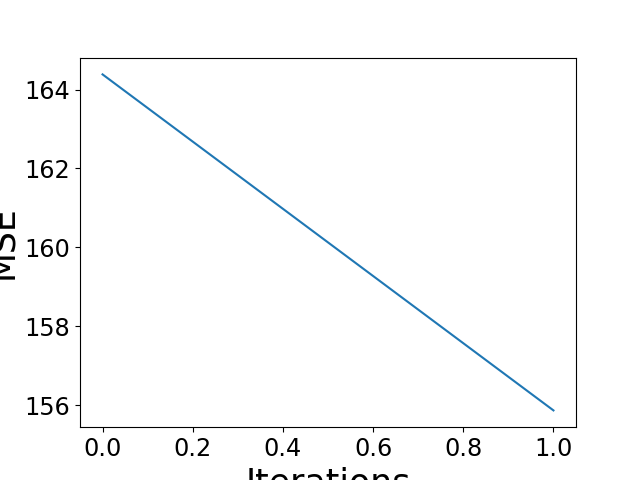

Text(0, 0.5, 'MSE')

In [12]:
import matplotlib.pyplot as plt
%matplotlib notebook
fig,ax = plt.subplots()

ax.plot(optim.mse_error)

ax.tick_params(labelsize='xx-large')

ax.set_xlabel("Iterations",fontsize=25)
ax.set_ylabel("MSE",fontsize=25)


# ax.legend(fontsize='large')

### Store parameter values obtained over the entire optimization run

In [14]:
yields= []
final_params=[]
mse_error = []
for i in range(len(optim.yield_per_iter)):
    yields.append(optim.yield_per_iter[i])
    params=[]
    for j in range(len(optim.parameter_history[i])):
        params.append(optim.parameter_history[i][j])
    final_params.append(params)
    mse_error.append(optim.mse_error[i])
    
sorted_yields=np.array(yields)#[sort_indx]
sorted_params = np.array(final_params)#[sort_indx]
mse_error = np.array(mse_error)

print(sorted_params[-1])

[0.9 1.1 1.1]


### Select parameter values with min error

In [15]:
min_indx = np.argmin(mse_error)

print("Params: ",list(sorted_params[min_indx]))
print(mse_error[min_indx])

Params:  [0.9000000000810331, 1.099999999858147, 1.0999999998110033]
155.87017822265625


## Storing parameter values in a file

In [ ]:
#Writing all solutions to a file

klabels=['k'+str(i) for i in range(len(vec_rn.kon))]
header = '#Yield\t' + "\t".join(klabels) + "\tt50\tt85\tt95\n"

files_range = [str(f) for f in files_range]
filestr = ",".join(files_range)


with open("rategrowth/Solutions_Conc_Homorates_New_01",'a') as fl:
    fl.write(header)
    fl.write("# Range of Concentrations: %s\n" %filestr)
    for i in range(len(sorted_yields)):
        fl.write("%f" %(sorted_yields[i]))
        fl.write("\t%f" %(mse_error[i]))
        for j in range((sorted_params[i].shape[0])):
            
            fl.write("\t%f" %(sorted_params[i][j]))
        fl.write("\n")
        
                 
